In [1]:
import multiprocessing 
print(multiprocessing.cpu_count())

8


In [2]:
import numpy as np

In [3]:
# arr = np.ones(10**9, dtype='float128')

In [4]:
import cvxopt
import pandas as pd
import numpy as np
from cvxopt import solvers, matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt  
import math
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
from sklearn.svm import SVC
from scipy.spatial.distance import pdist, squareform
import scipy
import joblib



In [5]:
gama = 0.05

In [6]:
# train_path = "/content/drive/My Drive/ML/fashion_mnist/train.csv"
# test_path = "/content/drive/My Drive/ML/fashion_mnist/test.csv"
# val_path = "/content/drive/My Drive/ML/fashion_mnist/val.csv"

In [8]:
train_path = "data/train.csv"
test_path = "data/test.csv"
val_path = "data/val.csv"

In [9]:
def readData(path, c1, c2):
	data = pd.read_csv(path, header=None)

	last_column = data.shape[1]-1
	data = filterData(c1, c2, data)

	# y_data = setY_1(data[last_column], c2, c1)
	x_data = scaleData(data.drop(last_column,1))
	y_data = data[last_column]

	return np.array(x_data), np.array(y_data).reshape(-1,1)


In [10]:
def readDataUnfiltered(path):
    data = pd.read_csv(path, header=None)

    last_column = data.shape[1]-1
    # data = filterData(c1, c2, data)

    x_data = scaleData(data.drop(last_column,1))
    y_data = data[last_column]


    return np.array(x_data), np.array(y_data).reshape(-1,1)

In [11]:
def filterData(c1, c2, data):
	last_column = data.shape[1]-1

	r_data = data[(data[last_column]==c1) | (data[last_column]==c2)]
	return r_data 

In [12]:
def setY_1(y, pos_class, neg_class):
    y[y==pos_class] = 1
    y[y==neg_class] = -1

    return y


In [13]:
def scaleData(data):
    return data / 255

In [14]:
def getP(y_train, x_train, kernel):
    m = y_train.shape[0]
    KernelMatrix = None
    if kernel == linear_kernel:
        KernelMatrix = (x_train@x_train.T)
        P = (y_train@y_train.T) * KernelMatrix
        return matrix(P), KernelMatrix
    if kernel == gaussian_kernel:
        print("Calculating P")
        # pairwise_sq_dists = squareform(pdist(x_train, 'sqeuclidean'))
        # KernelMatrix = np.exp(-pairwise_sq_dists * gama)
        KernelMatrix = np.exp( -gama*(cdist(x_train, x_train,'sqeuclidean')))
        P = (y_train@y_train.T) * KernelMatrix
        # print("y")
        # print(y_train)
        # print("yy.t")
        # print(y_train@y_train.T)
        # print("k")
        # print(KernelMatrix)

        return matrix(P), KernelMatrix

In [15]:

def getq(m):
    q = -np.ones((m,1))
    return matrix(q)


In [16]:
def getGh(m, C):
    G1 = np.identity(m)
    G = np.vstack((-G1, G1))

    H1 = np.zeros((m,1))
    H2 = C * np.ones((m,1))
    h = np.vstack((H1, H2))

    return matrix(G), matrix(h)


In [17]:
def getAb(y_train):
    A = y_train.T
    b = np.zeros(1)
    return matrix(A), matrix(b)


In [18]:
def linear_kernel(x, z):
    return (x.T)@z


In [19]:
def gaussian_kernel(x, z):
    return np.exp((-np.linalg.norm(x-z)**2) * gama)

In [20]:
def getWtX(alpha, Y, X, x, kernel):
    m = Y.shape[0]
    ans = 0
    for i in range(m):
        if(alpha[i]==0):
            continue
        ans+= alpha[i] * Y[i] * kernel(X[i].reshape(-1,1), x.reshape(-1,1))
    return ans


In [21]:
def getb(alpha, Y, X, kernel):
    print("calculating b")
    ans = 0
    m = Y.shape[0]
    max1 = -float('inf')
    min1 = float('inf')
    for i in tqdm(range(m)):
        wtx = getWtX(alpha, Y, X, X[i], kernel)
        if Y[i] == -1:
            max1 = max(max1, wtx)
        elif Y[i] == 1:
            min1 = min(min1, wtx)

    b = -1*(max1 + min1)/2
    print("b", b)
    return b

In [22]:
def getGaussb(alpha,alpha_f, X, X_f, Y, Y_f, kernalMatrix):
  print("alpha_f",alpha_f.shape)
  print("Y_f",Y_f.shape)
  print("X_f",X_f.shape)
  print("X",X.shape)
  wtx = (   np.exp(-1*cdist(X, X_f, "sqeuclidean")*gama) @ (alpha_f*Y_f) )
  print("wtx",wtx.shape)
  t1 = np.max(wtx[np.where(Y==-1)])
  t2 = np.min(wtx[np.where(Y==1)])
  b = -1 * (t1 + t2) /2
  print("gb", b)
  return b




In [23]:
def getbb(alpha, X,Y, kernalMatrix):
  temp = alpha * Y * kernalMatrix
  print(temp.shape)
  # filter temp where y = -1 and 1
  m,n = X.shape
  Yy = np.repeat(Y,m,axis=1)
  temp1 = temp[np.where(Yy ==1)].reshape(-1, m)
  temp2 = temp[np.where(Yy ==-1)].reshape(-1, m)
  print(Yy.shape)
  print(temp1.shape)
  print(temp2.shape)

  b1 = np.max(np.sum(temp1, axis=0))
  b2 = np.min(np.sum(temp2, axis=0))
  b = -1*(b1+b2)/2
  print("bb", b)

  return b

In [24]:

def calculateAccuracy(actual, predicted):
    count = 0
    for y1, y2 in zip(actual, predicted):
        if y1==y2:
            count+=1
    return count/len(predicted)

In [46]:
def plot_cm(actual, predicted, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(actual, predicted, labels=labels)
    df_cm = pd.DataFrame(cm, columns=np.unique(actual), index = np.unique(actual))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    # plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size

    ax = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [26]:
class BiSVM:

    def replaceLabelsBefore(self, y):
      y = np.where(y==self.neg_class, -1, y)
      y = np.where(y==self.pos_class, 1, y)
      return y

    def replaceLabelsAfter(self, y):
      # y = np.where(y==100, self.pos_class, y)
      # print(self.pos_class)
      y = np.where(y==1, self.pos_class, y)
      # print(y)
      # print(y.max())
      # print(y.min())
      y = np.where(y==-1, self.neg_class, y)
      # print(y)
      # print(y.max())
      # print(y.min())
      return y

    def predictGauss(self, X_test):
        kernel = self.kernel
        alpha = self.alpha
        Y = self.Y
        X = self.X
        b = self.b
        wtx =  np.exp(-1*cdist(X_test, X, "sqeuclidean")*gama) @ (alpha*Y) 
        return self.replaceLabelsAfter(np.sign(wtx+b))



    def predict(self, X_test):
        kernel = self.kernel
        if kernel ==gaussian_kernel:
          return self.predictGauss(X_test)
        alpha = self.alpha
        Y = self.Y
        X = self.X
        b = self.b
        p =  np.array([ 1  if getWtX(alpha, Y, X, el, kernel) + b > 0 else -1  for el in tqdm(X_test)])
        p = self.replaceLabelsAfter(p)
        return np.array(p).astype(int)

    def getParameters(self):
        parameter = {}
        parameter["alpha"]  = self.alpha
        parameter["b"] = self.b
        parameter["pos_class"] = self.pos_class
        parameter["neg_class"] = self.neg_class
        parameter["kernel"] = self.kernel
        parameter["b"] = self.b
        parameter["w"] = self.w
        parameter["count_sv"] = self.count_sv
        return parameter

    def fit(self, train_x, train_y, pos_class, neg_class, kernel):
        self.pos_class = pos_class
        self.neg_class = neg_class
        self.kernel = kernel

        train_y = self.replaceLabelsBefore(train_y)

        cut_off = 1e-5
        C = 1
        m,n = train_x.shape
        P, KernelMatrix = getP(train_y, train_x, kernel)
        q = getq(m)
        G, h = getGh(m, C)
        A, b = getAb(train_y)

        self.KernelMatrix = KernelMatrix

        sol = solvers.qp(P,q,G,h,A,b)
        # print(sol['x'])

        alpha = np.array(sol['x']).reshape(-1,1)

        count_sv = len(alpha[alpha>cut_off])
        print(f"No. of support vectors:",  count_sv)

        alpha_index = alpha>cut_off
        alpha[alpha<cut_off] = 0

        alpha_index1 = np.where(alpha_index)[0]

        train_x_f = np.take(train_x, alpha_index1, axis=0)

        alpha_f = (alpha*alpha_index)
        alpha_f = (alpha_f[alpha_f!=0]).reshape(-1,1)

        train_y_f = (train_y*alpha_index)
        train_y_f = (train_y_f[train_y_f!=0]).reshape(-1,1)
        if kernel == gaussian_kernel:
          b = getGaussb(alpha,alpha_f, train_x, train_x_f, train_y, train_y_f, KernelMatrix)
        else:
          b = getb(alpha_f, train_y_f, train_x_f, kernel)
        # bb = getbb(alpha, train_x,train_y, KernelMatrix)
        

        # self.bb = bb
        self.count_sv = count_sv
        self.alpha_f = alpha_f
        self.train_x_f = train_x_f
        self.train_y_f = train_y_f
        self.b = b
        self.w = None

        self.alpha = alpha
        self.X = train_x
        self.Y = train_y

        

        if kernel == linear_kernel:
            w = np.sum(train_y_f * alpha_f * train_x_f, axis=0).reshape(-1,1)
            self.w = w

        return True
        
       

In [27]:
# def plot_cm(actual, predicted):
#     cm = confusion_matrix(actual, predicted)
#     df_cm = pd.DataFrame(cm, columns=np.unique(actual), index = np.unique(actual))
#     df_cm.index.name = 'Actual'
#     df_cm.columns.name = 'Predicted'
#     # plt.figure(figsize = (10,7))
#     sns.set(font_scale=1.4)#for label size

#     ax = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
#     plt.show()


# Linear SVM

In [28]:
d = 5
c1 = d
c2 = (d+1)%10

train_x, train_y = readData(train_path, c1, c2)
test_x, test_y = readData(test_path, c1, c2)
val_x, val_y = readData(val_path, c1, c2)

In [29]:
# train_x, train_y = readDataUnfiltered(train_path)
# test_x, test_y = readDataUnfiltered(test_path)
# val_x, val_y = readDataUnfiltered(val_path)

In [30]:
train_x.shape

(4500, 784)

In [31]:
# yy = np.put(train_y, [-1, 1], [5, 6])

In [32]:
# yy

In [33]:
BiSVM_model = BiSVM()

In [34]:
start_time = time.time()
BiSVM_model.fit(train_x, train_y, c2, c1, linear_kernel)
print(f"Time taken = {time.time() - start_time} sec")

     pcost       dcost       gap    pres   dres
 0: -2.8076e+02 -8.3088e+03  4e+04  3e+00  2e-12
 1: -1.5849e+02 -4.4639e+03  9e+03  4e-01  1e-12
 2: -5.1865e+01 -1.2686e+03  2e+03  9e-02  6e-13
 3: -2.1440e+01 -7.0693e+02  1e+03  4e-02  3e-13
 4: -3.8988e+00 -1.9875e+02  3e+02  8e-03  1e-13
 5: -1.3115e+00 -1.0143e+02  2e+02  4e-03  4e-14
 6: -4.5724e-01 -4.1303e+01  6e+01  1e-03  2e-14
 7: -2.6273e-02 -2.0037e+01  3e+01  5e-04  1e-14
 8: -3.8091e-01 -7.1544e+00  8e+00  1e-04  1e-14
 9: -6.0363e-01 -3.4105e+00  3e+00  2e-16  1e-14
10: -9.8611e-01 -2.2986e+00  1e+00  2e-16  1e-14
11: -1.1165e+00 -2.0484e+00  9e-01  8e-16  1e-14
12: -1.2839e+00 -1.6996e+00  4e-01  2e-16  1e-14
13: -1.3432e+00 -1.5701e+00  2e-01  2e-16  1e-14
14: -1.4108e+00 -1.4693e+00  6e-02  4e-16  1e-14
15: -1.4351e+00 -1.4385e+00  3e-03  2e-16  1e-14
16: -1.4367e+00 -1.4367e+00  5e-05  3e-16  1e-14


100%|██████████| 86/86 [00:00<00:00, 1334.54it/s]

17: -1.4367e+00 -1.4367e+00  6e-07  7e-16  1e-14
Optimal solution found.
No. of support vectors: 86
calculating b
b [[-0.49050306]]
Time taken = 34.255138874053955 sec


In [35]:
BiSVM_model.count_sv

86

In [36]:
BiSVM_model.w

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 8.14385650e-04],
       [ 4.07192825e-04],
       [ 2.75384072e-03],
       [ 7.38448735e-03],
       [ 6.31474771e-03],
       [ 1.77914838e-02],
       [ 4.82141858e-02],
       [ 2.55315834e-02],
       [ 3.82036803e-02],
       [ 1.32396394e-01],
       [ 7.42205649e-02],
       [ 1.31544141e-01],
       [ 1.54509806e-01],
       [ 1.34075824e-01],
       [ 7.69645356e-02],
       [ 3.40328188e-02],
       [ 1.21710417e-02],
       [-1.23804977e-02],
       [ 3.23233303e-02],
       [-2.55740307e-02],
       [-1.57690088e-02],
       [ 1.13719635e-02],
       [-2.79384735e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.17244950e-03],
       [ 3.39435896e-02],
       [ 5.32311348e-02],
       [ 7.15217464e-02],
       [ 6.80748314e-02],
       [ 9.84484075e-02],
       [ 7.7

In [37]:
bisvm_parameter = BiSVM_model.getParameters()

In [38]:
start_time = time.time()
predicted_train =  BiSVM_model.predict(train_x)
print(f"Time taken = {time.time() - start_time} sec")

100%|██████████| 4500/4500 [00:26<00:00, 168.42it/s]

Time taken = 26.721782445907593 sec


In [39]:
train_acc = calculateAccuracy(predicted_train, train_y)

In [40]:
train_f1 = f1_score(train_y, predicted_train, pos_label=c2)

In [41]:
print(f"Train Accuracy:", train_acc)
print(f"Train F1 score:", train_f1)

Train Accuracy: 1.0
Train F1 score: 1.0


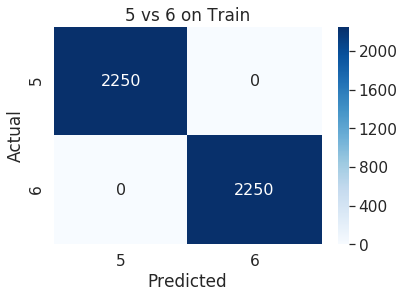

In [59]:
plot_cm(train_y.astype(int), predicted_train.astype(int), labels=[6,5], title="5 vs 6 on Train")

In [ ]:
#validation

In [52]:
start_time = time.time()
predicted_val = BiSVM_model.predict(val_x)
print(f"Time taken = {time.time() - start_time} sec")

100%|██████████| 500/500 [00:03<00:00, 165.98it/s]

Time taken = 3.0142338275909424 sec


In [53]:
val_acc = calculateAccuracy(predicted_val, val_y)

In [54]:
val_f1 = f1_score(val_y, predicted_val, pos_label=c1)

In [55]:
print(f"Val Accuracy:", val_acc)
print(f"Val F1 score:", val_f1)

Val Accuracy: 0.998
Val F1 score: 0.9979959919839679


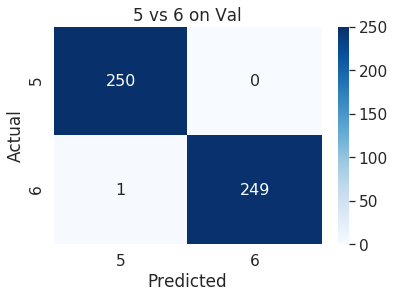

In [60]:
plot_cm(val_y.astype(int), predicted_val.astype(int), labels=[c2,c1],  title="5 vs 6 on Val")

In [ ]:
# test

In [61]:
start_time = time.time()
predicted_test = BiSVM_model.predict(test_x)
print(f"Time taken = {time.time() - start_time} sec")

100%|██████████| 1000/1000 [00:06<00:00, 165.68it/s]

Time taken = 6.037841081619263 sec


In [62]:
test_acc = calculateAccuracy(predicted_test, test_y)

In [63]:
test_f1 = f1_score(test_y, predicted_test, pos_label=c1)

In [120]:
print(f"Test Accuracy:", val_acc)
print(f"Test F1 score:", val_f1)

Test Accuracy: 0.998
Test F1 score: 0.9979959919839679


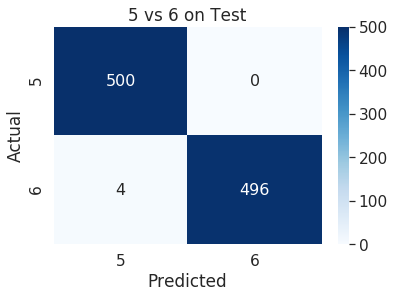

In [64]:
plot_cm(test_y.astype(int), predicted_test.astype(int), labels=[c2,c1],  title="5 vs 6 on Test")

## Linear SVM SKLearn

In [65]:
# SKLearn

In [66]:
clf_linear_model = SVC(kernel="linear")

In [67]:
start_time = time.time()
clf_linear_model.fit(train_x, train_y)
print(f"Time taken = {time.time() - start_time} sec")

/home/merajahmed/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time taken = 0.4044985771179199 sec


In [68]:
clf_linear_model.intercept_

array([-0.49029701])

In [69]:
print("SKLearn b", clf_linear_model.intercept_)

SKLearn b [-0.49029701]


In [128]:
clf_linear_model.coef_.shape

(1, 784)

In [131]:
w_diff = np.linalg.norm(clf_linear_model.coef_ - (BiSVM_model.w).reshape(1,-1))

In [132]:
print("Norm distance between w", w_diff)

Norm distance between w 0.0008548542758285319


In [70]:
print("SKLearn w", clf_linear_model.coef_)

SKLearn w [[ 0.00000000e+00  0.00000000e+00  8.14655870e-04  4.07327935e-04
   2.75429824e-03  7.39204991e-03  6.31396000e-03  1.77809297e-02
   4.82158760e-02  2.55387815e-02  3.81927421e-02  1.32365117e-01
   7.42228073e-02  1.31566402e-01  1.54549375e-01  1.34006424e-01
   7.69225545e-02  3.40269244e-02  1.21603267e-02 -1.23953066e-02
   3.23079776e-02 -2.56100248e-02 -1.57920201e-02  1.13826318e-02
  -1.73996638e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.17386205e-03  3.39477723e-02  5.32374582e-02  7.15180426e-02
   6.80603343e-02  9.84392131e-02  7.78393153e-02  1.23828573e-01
   2.05341902e-01  2.05785517e-01  1.71152287e-01  2.97258176e-01
   5.78978019e-02 -2.03615457e-02 -6.88319822e-02 -2.97549603e-02
  -4.82639496e-02 -9.40746212e-02 -3.60782900e-02  1.47226748e-02
   9.97015437e-06  5.30386500e-04 -8.29292344e-05  0.00000000e+00
   6.00285634e-05  0.00000000e+00  3.46228745e-03  2.85129555e-03


In [71]:
clf_linear_model.coef_.shape

(1, 784)

In [72]:
clf_linear_model.n_support_

array([64, 21], dtype=int32)

In [73]:
print(f"SKLearn NSV", clf_linear_model.n_support_)

SKLearn NSV [64 21]


In [74]:
# train

In [75]:
start_time = time.time()
clf_linear_pred = clf_linear_model.predict(train_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.24721288681030273 sec


In [76]:
train_sk_l_acc = calculateAccuracy(train_y,clf_linear_pred)

In [77]:
train_sk_l_f1 = f1_score(train_y,clf_linear_pred, pos_label=c1)

In [78]:
print(f"Train Accuracy:", train_sk_l_acc)
print(f"Train F1 score:", train_sk_l_f1)

Train Accuracy: 1.0
Train F1 score: 1.0


In [79]:
#Val

In [80]:
start_time = time.time()
clf_linear_pred_val = clf_linear_model.predict(val_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.028174161911010742 sec


In [81]:
val_sk_l_acc = calculateAccuracy(val_y,clf_linear_pred_val)
val_sk_l_f1 = f1_score(val_y,clf_linear_pred_val, pos_label=c1)

In [82]:
print(f"Val Accuracy:", val_sk_l_acc)
print(f"Val F1 score:", val_sk_l_f1)

Val Accuracy: 0.998
Val F1 score: 0.9979959919839679


In [83]:
#test

In [84]:
start_time = time.time()
clf_linear_pred_test = clf_linear_model.predict(test_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.058469295501708984 sec


In [85]:
test_sk_l_acc = calculateAccuracy(test_y,clf_linear_pred_test)
test_sk_l_f1 = f1_score(test_y,clf_linear_pred_test, pos_label=c1)

In [86]:
print(f"Test Accuracy:", test_sk_l_acc)
print(f"Test F1 score:", test_sk_l_f1)

Test Accuracy: 0.996
Test F1 score: 0.9959839357429718


In [87]:
# Gaussian

# Gaussian

In [88]:
## Gaussian Manual

## Gaussian Manual

In [89]:
train_x.shape

(4500, 784)

In [90]:
BiSVM_model_gauss = BiSVM()

In [91]:
start_time = time.time()
BiSVM_model_gauss.fit(train_x, train_y, c1, c2, gaussian_kernel)
print(f"Time taken = {time.time() - start_time} sec")

Calculating P
     pcost       dcost       gap    pres   dres
 0: -2.0533e+02 -7.5506e+03  3e+04  2e+00  2e-15
 1: -1.2813e+02 -3.9857e+03  6e+03  2e-01  1e-15
 2: -9.5987e+01 -7.8644e+02  8e+02  2e-02  5e-15
 3: -1.4760e+02 -3.3431e+02  2e+02  5e-03  3e-15
 4: -1.6699e+02 -2.3327e+02  7e+01  1e-03  2e-15
 5: -1.7565e+02 -2.0037e+02  3e+01  2e-04  1e-15
 6: -1.7993e+02 -1.8778e+02  8e+00  3e-05  1e-15
 7: -1.8146e+02 -1.8393e+02  2e+00  2e-15  1e-15
 8: -1.8213e+02 -1.8255e+02  4e-01  2e-14  1e-15
 9: -1.8227e+02 -1.8229e+02  3e-02  9e-15  2e-15
10: -1.8228e+02 -1.8228e+02  4e-04  5e-15  2e-15
11: -1.8228e+02 -1.8228e+02  7e-06  2e-14  2e-15
Optimal solution found.
No. of support vectors: 1130
alpha_f (1130, 1)
Y_f (1130, 1)
X_f (1130, 784)
X (4500, 784)
wtx (4500, 1)
gb -0.08654572282511158
Time taken = 34.1121563911438 sec


In [92]:
print(BiSVM_model_gauss.b)

-0.08654572282511158


In [93]:
# train

In [94]:
start_time = time.time()
g_train_pred = BiSVM_model_gauss.predictGauss(train_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 8.309123992919922 sec


Val Accuracy: 1.0
Val F1 score: 1.0


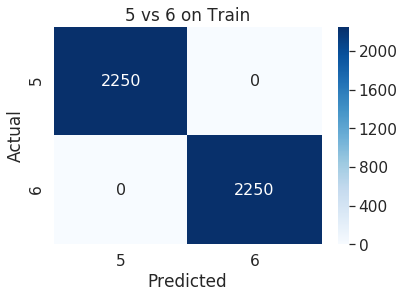

In [121]:
g_train_acc = calculateAccuracy(g_train_pred, train_y)
g_train_f1 = f1_score(train_y, g_train_pred, pos_label=c1)
print(f"Val Accuracy:", g_train_acc)
print(f"Val F1 score:", g_train_f1)
plot_cm(train_y.astype(int), g_train_pred.astype(int), labels=[c2,c1], title ="5 vs 6 on Train")

In [96]:
# val

In [97]:
start_time = time.time()
g_val_pred = BiSVM_model_gauss.predictGauss(val_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.9912939071655273 sec


Val Accuracy: 0.996
Val F1 score: 0.9959839357429718


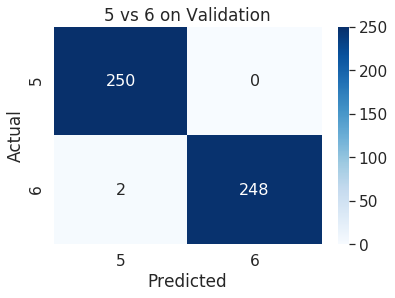

In [122]:
g_val_acc = calculateAccuracy(g_val_pred, val_y)
g_val_f1 = f1_score(val_y, g_val_pred, pos_label=c1)
print(f"Val Accuracy:", g_val_acc)
print(f"Val F1 score:", g_val_f1)
plot_cm(val_y.astype(int), g_val_pred.astype(int), labels=[c2,c1],  title ="5 vs 6 on Validation")

In [99]:
# test

In [100]:
start_time = time.time()
g_test_pred = BiSVM_model_gauss.predictGauss(test_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 1.843393087387085 sec


Val Accuracy: 0.998
Val F1 score: 0.9979959919839679


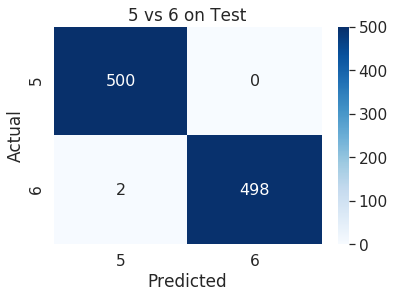

In [123]:
g_test_acc = calculateAccuracy(g_test_pred, test_y)
g_test_f1 = f1_score(test_y, g_test_pred, pos_label=c1)
print(f"Val Accuracy:", g_test_acc)
print(f"Val F1 score:", g_test_f1)
plot_cm(test_y.astype(int), g_test_pred.astype(int), labels=[c2,c1], title="5 vs 6 on Test")

In [102]:
# joblib.dump(BiSVM_model_gauss, "/content/drive/My Drive/ML/SVM/MultiClass/BiSVM_model_gauss_j")

## Gaussian SKLearn

In [103]:
# sklearn Gaussian

In [104]:
clf_gauss = SVC(gamma=gama)

In [105]:
start_time = time.time()
clf_gauss.fit(train_x, train_y)
print(f"Time taken = {time.time() - start_time} sec")

/home/merajahmed/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time taken = 3.6342804431915283 sec


In [106]:
print("b:",clf_gauss.intercept_)
print("nsv",clf_gauss.n_support_ )

b: [-0.12264118]
nsv [631 492]


In [107]:
#train predict

In [108]:
start_time = time.time()
g_predicted_train  = clf_gauss.predict(train_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 3.2920498847961426 sec


In [109]:
g_acc_train = calculateAccuracy(g_predicted_train, train_y)
g_f1_train = f1_score(train_y, g_predicted_train, pos_label=c2)

In [110]:
print(f"Train Accuracy:", g_acc_train)
print(f"Train F1 score:", g_f1_train)

Train Accuracy: 1.0
Train F1 score: 1.0


In [111]:
#validation

In [112]:
start_time = time.time()
g_predicted_val  = clf_gauss.predict(val_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.36039137840270996 sec


In [113]:
g_acc_val = calculateAccuracy(g_predicted_val, val_y)
g_f1_val = f1_score(val_y, g_predicted_val, pos_label=c2)

In [114]:
print(f"Val Accuracy:", g_acc_val)
print(f"Val F1 score:", g_f1_val)

Val Accuracy: 0.996
Val F1 score: 0.996


In [115]:
# test

In [116]:
start_time = time.time()
g_predicted_test  = clf_gauss.predict(test_x)
print(f"Time taken = {time.time() - start_time} sec")

Time taken = 0.7180986404418945 sec


In [117]:
g_acc_test = calculateAccuracy(g_predicted_test, test_y)
g_f1_test = f1_score(test_y, g_predicted_test, pos_label=c2)

In [118]:
print(f"Test Accuracy:", g_acc_test)
print(f"Test F1 score:", g_f1_test)

Test Accuracy: 1.0
Test F1 score: 1.0
